In [2]:
from rmgen_ds.parameters_scene import (
    ParametersScene, load_parameters_scene,
    ParametersWall, ParametersWallOpening
)
from sionna.rt import Scene, SceneObject, ITURadioMaterial, load_scene, Camera
import trimesh
from pathlib import Path
import numpy as np
from shapely.geometry import box, Polygon, JOIN_STYLE
import shapely as shp
import shapely.plotting
import shapely.validation
import tempfile
import matplotlib.pyplot as plt
from skimage.draw import polygon


# def tesselate_wall_with_openings(wall, openings, wall_height):
#     """
#     wall: ParametersWall
#     openings: list of ParametersWallOpening
#     wall_height: float
#     returns: trimesh.Trimesh
#     """

#     # Wall vector and local axes
#     wx, wy = wall.from_xy
#     tx, ty = wall.to_xy
#     wall_vec = np.array([tx-wx, ty-wy, 0.])
#     wall_len = np.linalg.norm(wall_vec)
#     if wall_len == 0:
#         raise ValueError("Zero-length wall")
#     dir_along = wall_vec / wall_len
#     up = np.array([0., 0., 1.])
#     origin = np.array([wx, wy, 0.])

#     # Start with full wall rectangle in local coords
#     wall_poly = box(0, 0, wall_len, wall_height)

#     # Convert openings to wall-local 2D and subtract
#     for op in openings:
#         if not opening_on_wall(wall, op):
#             continue
#         # opening offset along wall
#         start = np.linalg.norm(np.array(op.from_xyz[:2]) - np.array([wx, wy]))
#         end = np.linalg.norm(np.array(op.to_xyz[:2]) - np.array([wx, wy]))
#         bottom = op.from_xyz[2]
#         top = op.to_xyz[2]
#         hole_poly = box(start, bottom, end, top)
#         wall_poly = wall_poly.difference(hole_poly)

#     # wall_poly is a shapely polygon (with holes)
#     verts2d, faces = trimesh.creation.triangulate_polygon(wall_poly)

#     verts3d = []
#     for v in verts2d:
#         X, Y = v
#         world = origin + dir_along * X + up * Y
#         verts3d.append(world)

#     return trimesh.Trimesh(vertices=np.array(verts3d),
#                            faces=faces,
#                            process=False)

# def opening_on_wall(wall, opening, tol=1e-6):
#     """
#     wall: ParametersWall
#     opening: ParametersWallOpening
#     tol: maximum perpendicular distance from wall
#     """
#     # Wall vector
#     wx, wy = wall.from_xy
#     tx, ty = wall.to_xy
#     wall_vec = np.array([tx - wx, ty - wy])
#     wall_len = np.linalg.norm(wall_vec)
#     if wall_len < tol:
#         return False
#     wall_dir = wall_vec / wall_len

#     # Opening center
#     ox, oy, _ = opening.from_xyz
#     cx, cy, _ = opening.to_xyz
#     op_start = np.array([ox, oy])
#     op_end = np.array([cx, cy])

#     # Vector from wall start to opening center
#     vec_to_start = op_start - np.array([wx, wy])
#     vec_to_end = op_end - np.array([wx, wy])

#     # Projection along wall
#     proj_len = np.dot(vec_to_start, wall_dir)
#     if proj_len < -tol or proj_len > wall_len + tol:
#         return False
#     # Projection along wall
#     proj_len = np.dot(vec_to_end, wall_dir)
#     if proj_len < -tol or proj_len > wall_len + tol:
#         return False

#     # Perpendicular distance to wall line
#     perp_vec = vec_to_end - proj_len * wall_dir
#     perp_dist = np.linalg.norm(perp_vec)
#     if perp_dist > tol:
#         return False

#     return True
def opening_on_wall(
    wall: ParametersWall, opening: ParametersWallOpening, eps=1e-2
) -> tuple[bool, bool]:
    wall_poly = Polygon(wall.corners_2d + (wall.corners_2d[0],))
    open_poly = Polygon(opening.corners_2d + (opening.corners_2d[0],))
    open_poly = open_poly.buffer(eps, join_style=JOIN_STYLE.mitre)

    if wall_poly.intersects(open_poly):
        on_wall = True
        diff = wall_poly.difference(open_poly)
        diff = diff.buffer(eps, join_style=JOIN_STYLE.mitre)
        if isinstance(diff, Polygon):
            # should be multipolygon, since we just divided it in 2
            print("poly")

            fig, ax = plt.subplots()
            shp.plotting.plot_polygon(wall_poly, ax=ax, add_points=False, facecolor="lightgray", edgecolor="black")
            shp.plotting.plot_polygon(open_poly, ax=ax, add_points=False, facecolor="red", edgecolor="black")
            # plt.show()

            fig, ax = plt.subplots()
            shp.plotting.plot_polygon(diff, ax=ax, add_points=False, facecolor="lightgray", edgecolor="black")
            plt.show()

            has_undesired_hole = True
        elif diff.geom_type == "MultiPolygon":
            has_undesired_hole = False
            if len(diff.geoms) != 2:
                print("2 geoms")
                has_undesired_hole = True
            for pol in diff.geoms:
                if len(pol.interiors) > 0:
                    print("has interrior")
                    has_undesired_hole = True
        else:
            has_undesired_hole = False
            raise ValueError("wut")
    else:
        on_wall = False
        has_undesired_hole = False

    return on_wall, has_undesired_hole

def wall_to_mesh(wall: ParametersWall, height: float):
    poly = trimesh.path.polygons.Polygon(wall.corners_2d + (wall.corners_2d[0],))
    if not poly.is_valid:
        poly = poly.buffer(0)
        if not poly.is_valid:
            raise ValueError(shp.validation.explain_validity(poly))
    return trimesh.creation.extrude_polygon(poly, height)

def opening_to_mesh(opening: ParametersWallOpening, eps=1e-4):
    poly = trimesh.path.polygons.Polygon(opening.corners_2d + (opening.corners_2d[0],))
    # subtraction does not work properly on overlapping planes so we add an eps
    poly = poly.buffer(eps, join_style=JOIN_STYLE.mitre)
    if not poly.is_valid:
        raise ValueError("OPAA")
    height = opening.z_range[1] - opening.z_range[0] + 2 * eps
    o_mesh = trimesh.creation.extrude_polygon(poly, height)
    o_mesh.apply_translation([0, 0, opening.z_range[0] - eps])
    return o_mesh

def update_scene_with_parameters(
    scene: Scene,
    parameters: ParametersScene,
) -> None:
    scene.frequency = parameters.frequency
    scene.bandwidth = parameters.bandwidth

    walls = []
    wall_openings = []
    for obj in parameters.objects:
        if obj.type == "wall":
            walls.append(obj)
        elif obj.type == "wall_opening":
            wall_openings.append(obj)
        elif obj.type == "ceiling":
            ceiling = obj
        elif obj.type == "floor":
            floor = obj

    DIR = Path("./objs")
    DIR.mkdir(exist_ok=True)
    wall_meshes = []
    closed_opening_meshes = []

    # check all openings are accounted for
    # and none are useless
    for c, opening in enumerate(wall_openings):
        found = False
        for i in range(len(walls)):
            on_wall, undesirable = opening_on_wall(walls[i], wall_openings[c])

            if undesirable:
                raise ValueError("Subtraction causes unexpected behavior")
            if on_wall:
                found = True

        if not found:
            print("Opa, buraco onde não tem parede?")
            # raise ValueError("NOO")

    for i in range(len(walls)):
        # print("i", i)
        wall_mesh = wall_to_mesh(walls[i], parameters.wall_height)
        openings = [
            opening
                for opening in wall_openings
                if opening_on_wall(walls[i], opening)[0]
        ]
        o_meshes = [opening_to_mesh(op) for op in openings]
        if o_meshes:
            combined_openings = trimesh.util.concatenate(o_meshes)
            # wall_meshes.append(combined_openings)
            wall_mesh = wall_mesh.difference(combined_openings)
        # print("wall_mesh.is_watertight", wall_mesh.is_watertight)
        # print("wall_mesh.is_volume", wall_mesh.is_volume)
        wall_mesh.fix_normals()
        if not wall_mesh.is_watertight:
            raise Exception("Something went wrong")
        wall_meshes.append(wall_mesh)

    # IMPL_2D = False
    # if IMPL_2D:
    #     for wall in walls:
    #         # find openings that intersect this wall
    #         relevant_openings = [op for op in wall_openings if opening_on_wall(wall, op)]
    #         mesh = tesselate_wall_with_openings(
    #             wall, [], wall_height=parameters.wall_height
    #         )
    #         wall_meshes.append(mesh)

    #     for c, opening in enumerate(wall_openings):
    #         found = False
    #         for i in range(len(walls)):
    #             if opening_on_wall(walls[i], opening):
    #                 found = True
    #         if not found:
    #             raise ValueError("NOO")

    for i, mesh in enumerate(wall_meshes):
        with tempfile.NamedTemporaryFile(delete=True, suffix=".ply") as tmp:
            tmp_path = str(Path(tmp.name).resolve())
            mesh.export(tmp_path)
            obj = SceneObject(
                fname=tmp_path,
                name=f"wall-{i}",
                radio_material=ITURadioMaterial(
                    f"wall-{i}-material",
                    walls[i].material,
                    thickness=walls[i].face_width,
                    color=(0.8, 0.1, 0.1)
                )
            )
            scene.edit(add=obj)

def parameters_scene_image(parameters: ParametersScene):
    walls = []
    wall_openings = []
    for obj in parameters.objects:
        if obj.type == "wall":
            walls.append(obj)
        elif obj.type == "wall_opening":
            wall_openings.append(obj)
        elif obj.type == "ceiling":
            ceiling = obj
        elif obj.type == "floor":
            floor = obj
    DIR = Path("./objs")
    DIR.mkdir(exist_ok=True)
    wall_meshes = []

    maxx, minx, maxy, miny = -np.inf, np.inf, -np.inf, np.inf
    for wall in walls:
        corners = np.array(wall.corners_2d)
        xs = corners[:, 0]
        ys = corners[:, 1]
        maxx = np.max([maxx, np.max(xs)])
        minx = np.min([minx, np.min(xs)])
        maxy = np.max([maxy, np.max(ys)])
        miny = np.min([miny, np.min(ys)])

    adj = lambda x: np.ceil(x * 1000).astype(int)
    w = adj(maxx - minx) + 1
    h = adj(maxy - miny) + 1
    img = np.zeros((w, h))

    def pol_from_corners(corners):
        corners = np.array(corners)
        xs = 1000*(corners[:, 0] - minx)
        ys = 1000*(corners[:, 1] - miny)

        rr, cc = polygon(
            ys,
            xs,
        )
        return rr, cc
        
    for wall in walls:
        rr, cc = pol_from_corners(wall.corners_2d)
        img[cc, rr] = 1
    # print("len(wall_openings)", len(wall_openings))
    # print()
    # print()
    # print("wall_openings", wall_openings)
    for opening in wall_openings:
        rr, cc = pol_from_corners(opening.corners_2d)
        if opening.state == "closed":
            img[cc, rr] = 2
        else:
            img[cc, rr] = 3

    # for c, opening in enumerate(wall_openings):
    #     found = False
    #     for i in range(len(walls)):
    #         if opening_on_wall(walls[i], opening):
    #             found = True
    #     if not found:
    #         raise ValueError("NOO")

    # for i, mesh in enumerate(wall_meshes):
    #     with tempfile.NamedTemporaryFile(delete=True, suffix=".ply") as tmp:
    #         tmp_path = str(Path(tmp.name).resolve())
    #         mesh.export(tmp_path)
    #         obj = SceneObject(
    #             fname=tmp_path,
    #             name=f"wall-{i}",
    #             radio_material=ITURadioMaterial(
    #                 f"wall-{i}-material",
    #                 walls[i].material,
    #                 thickness=walls[i].width,
    #                 color=(0.8, 0.1, 0.1)
    #             )
    #         )
    #         scene.edit(add=obj)
    fig = plt.figure()
    ax = fig.subplots()
    ax.set_axis_off()
    # rsh_walls
    im = ax.imshow(
        img
    )
    ax.set_title("ROOM")

    return fig, ax




2025-09-21 16:45:25 WARN main [PLYMesh] "tmp7cyhfedk.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpf71vls__.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpda7bds5h.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpkub8f31v.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmp8yvj4oxu.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmp0dtheg4p.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpaxrzbat7.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpnplkrn87.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmp7252pn8y.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmppi3p1mzp.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpgygzg9xh.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpsi48badt.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpeem8vjo4.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmp8c6fvshx.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmph4il5wgf.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpi6_qcjp9.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpf4nxohss.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmprog0aleh.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpjicdxtd0.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmptiy6a5l2.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmp5kiqpvqk.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmp2vgibjge.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

2025-09-21 16:45:25 WARN main [PLYMesh] "tmpscufakuu.ply": attributes without postfix are not handled for now: attribute "stl" ignored.

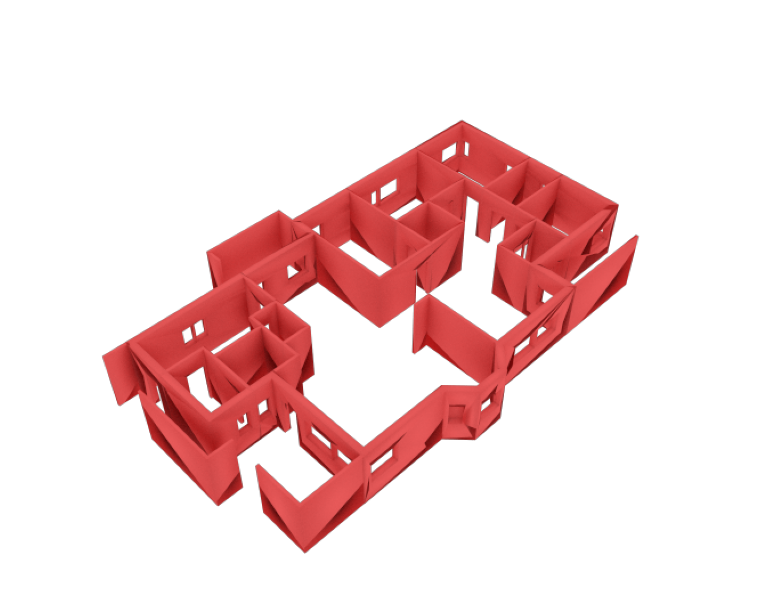

In [5]:
INPUTS_DIR = Path("./casa_inputs_4_corners_only/")
# INPUTS_DIR.mkdir(exist_ok=True)
# ps = [
#     cubicasa_p / "test.txt",
#     cubicasa_p / "train.txt",
#     cubicasa_p / "val.txt",
# ]
# fs = [
#     fname[1:] for p in ps for fname in p.read_text().split('\n')
# ][0:50]
fs = ["high_quality_architectural/2090/", "high_quality_architectural/1754/", "high_quality_architectural/6066/", "high_quality_architectural/6187/", "high_quality_architectural/5023/", "high_quality_architectural/9185/", "high_quality_architectural/6704/", "high_quality_architectural/2031/", "high_quality_architectural/32/", "high_quality_architectural/1284/", "high_quality_architectural/435/", "high_quality_architectural/1339/", "high_quality_architectural/1293/", "high_quality_architectural/1551/", "high_quality_architectural/1669/", "high_quality_architectural/52/", "high_quality_architectural/7696/", "high_quality_architectural/3527/", "high_quality_architectural/1683/", "high_quality_architectural/1845/", "high_quality_architectural/8726/", "high_quality_architectural/1242/", "high_quality_architectural/9422/", "high_quality_architectural/6452/", "high_quality_architectural/141/", "high_quality_architectural/3984/", "high_quality_architectural/4911/", "high_quality_architectural/6259/", "high_quality_architectural/4535/", "high_quality_architectural/1856/", "high_quality_architectural/6716/", "high_quality_architectural/5089/", "high_quality_architectural/1837/", "high_quality_architectural/287/", "high_quality_architectural/1165/", "high_quality_architectural/199/", "high_quality_architectural/1838/", "high_quality_architectural/7037/", "high_quality_architectural/1228/", "high_quality_architectural/1839/", "high_quality_architectural/1914/", "high_quality_architectural/8573/", "high_quality_architectural/2582/", "high_quality_architectural/1279/", "high_quality_architectural/5760/", "high_quality_architectural/2036/", "high_quality_architectural/8502/", "high_quality_architectural/2037/", "high_quality_architectural/1842/", "high_quality_architectural/3060/", "high_quality_architectural/5100/", "high_quality_architectural/7061/", "high_quality_architectural/541/", "high_quality_architectural/4589/", "high_quality_architectural/20000/", "high_quality_architectural/20019/", "high_quality_architectural/20021/", "high_quality_architectural/20022/", "high_quality_architectural/3516/", "colorful/11260/", "colorful/11485/", "colorful/11573/", "colorful/11867/", "colorful/12094/", "colorful/12200/", "colorful/12217/", "colorful/12625/", "colorful/12946/", "colorful/13138/", "colorful/13213/", "colorful/13254/", "colorful/13577/", "high_quality/9864/", "high_quality/4712/", "high_quality/9334/", "high_quality/8380/", "high_quality/5836/", "high_quality/3162/", "high_quality/8230/", "high_quality/7625/", "high_quality/3676/", "high_quality/3529/", "high_quality/4851/", "high_quality/5985/", "high_quality/1403/", "high_quality/3247/", "high_quality/7790/", "high_quality/3954/", "high_quality/5632/", "high_quality/488/", "high_quality/1510/", "high_quality/20174/", "high_quality/20197/", "high_quality_architectural/7691/", "high_quality_architectural/1141/", "high_quality_architectural/9270/", "colorful/3598/", "high_quality_architectural/6044/", "high_quality_architectural/2564/", "high_quality_architectural/4554/", "high_quality_architectural/449/", "high_quality_architectural/8650/", "high_quality_architectural/7595/", "high_quality_architectural/8096/", "high_quality_architectural/8368/", "high_quality_architectural/451/", "high_quality_architectural/4509/", "high_quality_architectural/1199/", "high_quality_architectural/9229/", "high_quality_architectural/5083/", "high_quality_architectural/8734/", "high_quality_architectural/7668/", "high_quality_architectural/9650/", "high_quality_architectural/530/", "high_quality_architectural/8424/", "high_quality_architectural/7050/", "high_quality_architectural/848/", "high_quality_architectural/954/", "high_quality_architectural/9138/", "high_quality_architectural/9465/", "high_quality_architectural/8416/", "high_quality_architectural/2079/", "high_quality_architectural/6672/", "high_quality_architectural/1169/", "high_quality_architectural/3604/", "high_quality_architectural/8809/", "high_quality_architectural/9557/", "high_quality_architectural/8100/", "high_quality_architectural/4906/", "high_quality_architectural/3118/", "high_quality_architectural/7805/", "high_quality_architectural/4064/", "high_quality_architectural/6334/", "high_quality_architectural/4821/", "high_quality_architectural/498/", "high_quality_architectural/5530/", "high_quality_architectural/381/", "high_quality_architectural/233/", "high_quality_architectural/8237/", "high_quality_architectural/1888/", "high_quality_architectural/4879/", "high_quality_architectural/1787/", "high_quality_architectural/9651/", "high_quality_architectural/3844/", "high_quality_architectural/4782/", "high_quality_architectural/9763/", "high_quality_architectural/4876/", "high_quality_architectural/8143/", "high_quality_architectural/1886/", "high_quality_architectural/144/", "high_quality_architectural/8509/", "high_quality_architectural/1789/", "high_quality_architectural/6249/", "high_quality_architectural/9524/", "high_quality_architectural/6208/", "high_quality_architectural/9043/", "high_quality_architectural/2577/", "high_quality_architectural/5067/", "high_quality_architectural/7711/", "high_quality_architectural/7918/", "high_quality_architectural/4711/", "high_quality_architectural/9054/", "high_quality_architectural/793/", "high_quality_architectural/8744/", "high_quality_architectural/1902/", "high_quality_architectural/1368/", "high_quality_architectural/4766/", "high_quality_architectural/5806/", "high_quality_architectural/8600/", "high_quality_architectural/2019/", "high_quality_architectural/1844/", "high_quality_architectural/9149/", "high_quality_architectural/1070/", "high_quality_architectural/1059/", "high_quality_architectural/5751/", "high_quality_architectural/2561/", "high_quality_architectural/5688/", "high_quality_architectural/8629/", "high_quality_architectural/6459/", "high_quality_architectural/3792/", "high_quality_architectural/8584/", "high_quality_architectural/985/", "high_quality_architectural/948/", "high_quality_architectural/3040/", "high_quality_architectural/617/", "high_quality_architectural/5901/", "high_quality_architectural/5049/", "high_quality_architectural/6594/", "high_quality_architectural/357/", "high_quality_architectural/1836/", "high_quality_architectural/5102/", "high_quality_architectural/902/", "high_quality_architectural/4526/", "high_quality_architectural/9532/", "high_quality_architectural/942/", "high_quality_architectural/1029/", "high_quality_architectural/4690/", "high_quality_architectural/9680/", "high_quality_architectural/5002/", "high_quality_architectural/7032/", "high_quality_architectural/4676/", "high_quality_architectural/5531/", "high_quality_architectural/8060/", "high_quality_architectural/7761/", "high_quality_architectural/277/", "high_quality_architectural/3570/", "high_quality_architectural/2563/", "high_quality_architectural/5920/", "high_quality_architectural/9454/", "high_quality_architectural/7592/", "high_quality_architectural/8791/", "high_quality_architectural/8407/", "high_quality_architectural/9837/", "high_quality_architectural/9971/", "high_quality_architectural/7772/", "high_quality_architectural/4974/", "high_quality_architectural/9685/", "high_quality_architectural/9977/", "high_quality_architectural/4951/", "high_quality_architectural/1855/", "high_quality_architectural/4741/", "high_quality_architectural/4592/", "high_quality_architectural/1483/", "high_quality_architectural/7666/", "high_quality_architectural/86/", "high_quality_architectural/3874/", "high_quality_architectural/8616/", "high_quality_architectural/911/", "high_quality_architectural/9037/", "high_quality_architectural/4595/", "high_quality_architectural/5946/", "high_quality_architectural/4848/", "high_quality_architectural/1047/", "high_quality_architectural/2050/", "high_quality_architectural/1828/", "high_quality_architectural/4865/", "high_quality_architectural/2580/", "high_quality_architectural/5830/", "high_quality_architectural/122/", "high_quality_architectural/3153/", "high_quality_architectural/6578/", "high_quality_architectural/9493/", "high_quality_architectural/9591/", "high_quality_architectural/5752/", "high_quality_architectural/1308/", "high_quality_architectural/9104/", "high_quality_architectural/5609/", "high_quality_architectural/6036/", "high_quality_architectural/232/", "high_quality_architectural/5923/", "high_quality_architectural/8218/", "high_quality_architectural/8341/", "high_quality_architectural/674/", "high_quality_architectural/1323/", "high_quality_architectural/3942/", "high_quality_architectural/3510/", "high_quality_architectural/1582/", "high_quality_architectural/9063/", "high_quality_architectural/6280/", "high_quality_architectural/9386/", "high_quality_architectural/5044/", "high_quality_architectural/8323/", "high_quality_architectural/3102/", "high_quality_architectural/312/", "high_quality_architectural/8021/", "high_quality_architectural/9342/", "high_quality_architectural/1338/", "high_quality_architectural/1653/", "high_quality_architectural/1000/", "high_quality_architectural/7650/", "high_quality_architectural/9295/", "high_quality_architectural/6083/", "high_quality_architectural/1225/", "high_quality_architectural/1512/", "high_quality_architectural/4772/", "high_quality_architectural/1018/", "high_quality_architectural/7853/", "high_quality_architectural/7965/", "high_quality_architectural/68/", "high_quality_architectural/5016/", "high_quality_architectural/1409/", "high_quality_architectural/9782/", "high_quality_architectural/8333/", "high_quality_architectural/5065/", "high_quality_architectural/7838/", "high_quality_architectural/1803/", "high_quality_architectural/3502/", "high_quality_architectural/8582/", "high_quality_architectural/8311/", "high_quality_architectural/8471/", "high_quality_architectural/5031/", "high_quality_architectural/6324/", "high_quality_architectural/1850/", "high_quality_architectural/821/", "high_quality_architectural/3665/", "high_quality_architectural/7649/", "high_quality_architectural/8469/", "high_quality_architectural/2164/", "high_quality_architectural/5575/", "high_quality_architectural/2185/", "high_quality_architectural/1252/", "high_quality_architectural/8601/", "high_quality_architectural/8535/", "high_quality_architectural/1833/", "high_quality_architectural/5157/", "high_quality_architectural/1561/", "high_quality_architectural/857/", "high_quality_architectural/9844/", "high_quality_architectural/862/", "high_quality_architectural/8593/", "high_quality_architectural/8302/", "high_quality_architectural/6110/", "high_quality_architectural/5934/", "high_quality_architectural/7590/", "high_quality_architectural/7791/", "high_quality_architectural/1357/", "high_quality_architectural/6003/", "high_quality_architectural/9937/", "high_quality_architectural/9034/", "high_quality_architectural/4884/", "high_quality_architectural/9677/", "high_quality_architectural/577/", "high_quality_architectural/3849/", "high_quality_architectural/3184/", "high_quality_architectural/1266/", "high_quality_architectural/7105/", "high_quality_architectural/1589/", "high_quality_architectural/9735/", "high_quality_architectural/9050/", "high_quality_architectural/678/", "high_quality_architectural/6261/", "high_quality_architectural/8199/", "high_quality_architectural/504/", "high_quality_architectural/2032/", "high_quality_architectural/3694/", "high_quality_architectural/7549/", "high_quality_architectural/931/", "high_quality_architectural/5604/", "high_quality_architectural/2177/", "high_quality_architectural/3865/", "high_quality_architectural/3915/", "high_quality_architectural/3766/", "high_quality_architectural/5611/", "high_quality_architectural/3710/", "high_quality_architectural/3222/", "high_quality_architectural/407/", "high_quality_architectural/8213/", "high_quality_architectural/5501/", "high_quality_architectural/1746/", "high_quality_architectural/913/", "high_quality_architectural/2005/", "high_quality_architectural/5958/", "high_quality_architectural/9348/", "high_quality_architectural/3590/", "high_quality_architectural/8805/", "high_quality_architectural/3032/", "high_quality_architectural/3926/", "high_quality_architectural/9222/", "high_quality_architectural/7005/", "high_quality_architectural/6394/", "high_quality_architectural/8327/", "high_quality_architectural/8705/", "high_quality_architectural/679/", "high_quality_architectural/6142/", "high_quality_architectural/162/", "high_quality_architectural/6441/", "high_quality_architectural/856/", "high_quality_architectural/9070/", "high_quality_architectural/4579/", "high_quality_architectural/5589/", "high_quality_architectural/9611/", "high_quality_architectural/1648/", "high_quality_architectural/703/", "high_quality_architectural/650/", "high_quality_architectural/7029/", "high_quality_architectural/6159/", "high_quality_architectural/16/", "high_quality_architectural/4549/", "high_quality_architectural/3873/", "high_quality_architectural/1859/", "high_quality_architectural/247/", "high_quality_architectural/1121/", "high_quality_architectural/627/", "high_quality_architectural/8596/", "high_quality_architectural/6484/", "high_quality_architectural/904/", "high_quality_architectural/4942/", "high_quality_architectural/3245/", "high_quality_architectural/1346/", "high_quality_architectural/6454/", "high_quality_architectural/2523/", "high_quality_architectural/8349/", "high_quality_architectural/5058/", "high_quality_architectural/7819/", "high_quality_architectural/8354/", "high_quality_architectural/1815/", "high_quality_architectural/6556/", "high_quality_architectural/1770/", "high_quality_architectural/6424/", "high_quality_architectural/6442/", "high_quality_architectural/4787/", "high_quality_architectural/9897/", "high_quality_architectural/8421/", "high_quality_architectural/8085/", "high_quality_architectural/9942/", "high_quality_architectural/2143/", "high_quality_architectural/9956/", "high_quality_architectural/7044/", "high_quality_architectural/6553/", "high_quality_architectural/832/", "high_quality_architectural/7118/", "high_quality_architectural/8823/", "high_quality_architectural/675/", "high_quality_architectural/39/", "high_quality_architectural/7089/", "high_quality_architectural/951/", "high_quality_architectural/1854/", "high_quality_architectural/6045/", "high_quality_architectural/5592/", "high_quality_architectural/9909/", "high_quality_architectural/5779/", "high_quality_architectural/7879/", "high_quality_architectural/157/", "high_quality_architectural/1227/", "high_quality_architectural/1576/", "high_quality_architectural/7861/", "high_quality_architectural/9154/", "high_quality_architectural/6581/", "high_quality_architectural/3871/", "high_quality_architectural/9984/", "high_quality_architectural/1816/", "high_quality_architectural/5825/", "high_quality_architectural/6453/", "high_quality_architectural/6542/", "high_quality_architectural/2058/", "high_quality_architectural/9822/", "high_quality_architectural/8002/", "high_quality_architectural/1216/", "high_quality_architectural/188/", "high_quality_architectural/9640/", "high_quality_architectural/6085/", "high_quality_architectural/8022/", "high_quality_architectural/4967/", "high_quality_architectural/7575/", "high_quality_architectural/520/", "high_quality_architectural/494/", "high_quality_architectural/6207/", "high_quality_architectural/1876/", "high_quality_architectural/8039/", "high_quality_architectural/8544/", "high_quality_architectural/7578/", "high_quality_architectural/811/", "high_quality_architectural/3960/", "high_quality_architectural/4786/", "high_quality_architectural/5770/", "high_quality_architectural/1520/", "high_quality_architectural/7893/", "high_quality_architectural/9350/", "high_quality_architectural/8216/", "high_quality_architectural/6306/", "high_quality_architectural/8321/", "high_quality_architectural/4993/", "high_quality_architectural/10002/", "high_quality_architectural/10007/", "high_quality_architectural/10019/", "high_quality_architectural/10020/", "high_quality_architectural/10023/", "high_quality_architectural/10034/", "high_quality_architectural/10039/", "high_quality_architectural/10044/", "high_quality_architectural/10070/", "high_quality_architectural/10075/", "high_quality_architectural/10102/", "high_quality_architectural/10113/", "high_quality_architectural/10119/", "high_quality_architectural/10126/", "high_quality_architectural/10128/", "high_quality_architectural/10142/", "high_quality_architectural/10143/", "high_quality_architectural/10149/", "high_quality_architectural/10150/", "high_quality_architectural/10162/", "high_quality_architectural/10163/", "high_quality_architectural/10170/", "high_quality_architectural/10179/", "high_quality_architectural/10195/", "high_quality_architectural/10196/", "high_quality_architectural/10209/", "high_quality_architectural/10213/", "high_quality_architectural/10217/", "high_quality_architectural/10218/", "high_quality_architectural/10219/", "high_quality_architectural/10231/", "high_quality_architectural/10238/", "high_quality_architectural/10251/", "high_quality_architectural/10254/", "high_quality_architectural/10262/", "high_quality_architectural/10285/", "high_quality_architectural/10288/", "high_quality_architectural/10290/", "high_quality_architectural/10303/", "high_quality_architectural/10311/", "high_quality_architectural/10319/", "high_quality_architectural/10353/", "high_quality_architectural/10359/", "high_quality_architectural/10365/", "high_quality_architectural/10366/", "high_quality_architectural/10370/", "high_quality_architectural/10380/", "high_quality_architectural/10428/", "high_quality_architectural/10432/", "high_quality_architectural/10468/", "high_quality_architectural/10487/", "high_quality_architectural/10490/", "high_quality_architectural/10498/", "high_quality_architectural/10515/", "high_quality_architectural/10539/", "high_quality_architectural/10540/", "high_quality_architectural/10547/", "high_quality_architectural/10548/", "high_quality_architectural/10571/", "high_quality_architectural/10581/", "high_quality_architectural/10599/", "high_quality_architectural/10616/", "high_quality_architectural/10624/", "high_quality_architectural/10632/", "high_quality_architectural/10634/", "high_quality_architectural/10643/", "high_quality_architectural/10662/", "high_quality_architectural/10678/", "high_quality_architectural/10712/", "high_quality_architectural/10717/", "high_quality_architectural/10719/", "high_quality_architectural/10738/", "high_quality_architectural/10745/", "high_quality_architectural/10755/", "high_quality_architectural/10756/", "high_quality_architectural/10759/", "high_quality_architectural/10771/", "high_quality_architectural/10775/", "high_quality_architectural/10782/", "high_quality_architectural/10783/", "high_quality_architectural/10786/", "high_quality_architectural/11000/", "high_quality_architectural/11001/", "high_quality_architectural/11002/", "high_quality_architectural/11003/", "high_quality_architectural/11007/", "high_quality_architectural/11009/", "high_quality_architectural/11011/", "high_quality_architectural/11012/", "high_quality_architectural/11015/", "high_quality_architectural/11017/", "high_quality_architectural/11019/", "high_quality_architectural/11022/", "high_quality_architectural/11023/", "high_quality_architectural/11024/", "high_quality_architectural/11027/", "high_quality_architectural/11032/", "high_quality_architectural/11049/", "high_quality_architectural/11051/", "high_quality_architectural/11063/", "high_quality_architectural/11069/", "high_quality_architectural/11083/", "high_quality_architectural/11096/", "high_quality_architectural/11100/", "high_quality_architectural/11109/", "high_quality_architectural/11112/", "high_quality_architectural/11118/", "high_quality_architectural/11122/", "high_quality_architectural/11140/", "high_quality_architectural/11152/", "high_quality_architectural/11154/", "high_quality_architectural/11169/", "high_quality_architectural/11172/", "high_quality_architectural/11177/", "high_quality_architectural/11180/", "high_quality_architectural/11206/", "high_quality_architectural/11209/", "high_quality_architectural/11213/", "high_quality_architectural/11220/", "high_quality_architectural/11224/", "high_quality_architectural/11237/", "high_quality_architectural/11238/", "high_quality_architectural/11279/", "high_quality_architectural/11297/", "high_quality_architectural/11300/", "high_quality_architectural/11311/", "high_quality_architectural/11321/", "high_quality_architectural/11327/", "high_quality_architectural/11335/", "high_quality_architectural/11339/", "high_quality_architectural/11354/", "high_quality_architectural/11374/", "high_quality_architectural/11408/", "high_quality_architectural/11409/", "high_quality_architectural/11410/", "high_quality_architectural/11412/", "high_quality_architectural/11421/", "high_quality_architectural/11426/", "high_quality_architectural/11465/", "high_quality_architectural/11475/", "high_quality_architectural/11477/", "high_quality_architectural/11487/", "high_quality_architectural/11508/", "high_quality_architectural/11511/", "high_quality_architectural/11514/", "high_quality_architectural/11520/", "high_quality_architectural/11526/", "high_quality_architectural/11530/", "high_quality_architectural/11554/", "high_quality_architectural/11556/", "high_quality_architectural/11557/", "high_quality_architectural/11587/", "high_quality_architectural/11593/", "high_quality_architectural/11604/", "high_quality_architectural/11616/", "high_quality_architectural/11621/", "high_quality_architectural/11642/", "high_quality_architectural/11678/", "high_quality_architectural/11679/", "high_quality_architectural/11694/", "high_quality_architectural/11697/", "high_quality_architectural/11714/", "high_quality_architectural/11718/", "high_quality_architectural/11721/", "high_quality_architectural/11727/", "high_quality_architectural/11800/", "high_quality_architectural/11807/", "high_quality_architectural/11815/", "high_quality_architectural/11833/", "high_quality_architectural/11862/", "high_quality_architectural/11865/", "high_quality_architectural/11869/", "high_quality_architectural/11919/", "high_quality_architectural/11921/", "high_quality_architectural/11931/", "high_quality_architectural/11932/", "high_quality_architectural/11949/", "high_quality_architectural/11950/", "high_quality_architectural/11953/", "high_quality_architectural/11967/", "high_quality_architectural/11978/", "high_quality_architectural/12020/", "high_quality_architectural/12034/", "high_quality_architectural/12040/", "high_quality_architectural/12041/", "high_quality_architectural/12042/", "high_quality_architectural/12048/", "high_quality_architectural/12059/", "high_quality_architectural/12062/", "high_quality_architectural/12073/", "high_quality_architectural/12083/", "high_quality_architectural/12084/", "high_quality_architectural/12093/", "high_quality_architectural/12117/", "high_quality_architectural/12119/", "high_quality_architectural/12125/", "high_quality_architectural/12167/", "high_quality_architectural/12177/", "high_quality_architectural/12179/", "high_quality_architectural/12203/", "high_quality_architectural/12213/", "high_quality_architectural/12216/", "high_quality_architectural/12241/", "high_quality_architectural/12242/", "high_quality_architectural/12258/", "high_quality_architectural/12262/", "high_quality_architectural/12273/", "high_quality_architectural/12281/", "high_quality_architectural/12289/", "high_quality_architectural/12440/", "high_quality_architectural/12443/", "high_quality_architectural/12446/", "high_quality_architectural/12454/", "high_quality_architectural/12497/", "high_quality_architectural/12556/", "high_quality_architectural/12563/", "high_quality_architectural/12569/", "high_quality_architectural/12573/", "high_quality_architectural/12575/", "high_quality_architectural/12576/", "high_quality_architectural/12578/", "high_quality_architectural/12579/", "high_quality_architectural/12582/", "high_quality_architectural/12583/", "high_quality_architectural/12584/", "high_quality_architectural/12585/", "high_quality_architectural/12586/", "high_quality_architectural/12596/", "high_quality_architectural/12617/", "high_quality_architectural/12635/", "high_quality_architectural/12638/", "high_quality_architectural/12643/", "high_quality_architectural/12661/", "high_quality_architectural/12672/", "high_quality_architectural/12676/", "high_quality_architectural/12677/", "high_quality_architectural/12684/", "high_quality_architectural/12707/", "high_quality_architectural/12710/", "high_quality_architectural/12732/", "high_quality_architectural/12734/", "high_quality_architectural/12747/", "high_quality_architectural/12756/", "high_quality_architectural/12770/", "high_quality_architectural/12777/", "high_quality_architectural/12821/", "high_quality_architectural/12823/", "high_quality_architectural/12844/", "high_quality_architectural/12845/", "high_quality_architectural/12851/", "high_quality_architectural/12859/", "high_quality_architectural/12860/", "high_quality_architectural/12865/", "high_quality_architectural/12884/", "high_quality_architectural/12889/", "high_quality_architectural/12903/", "high_quality_architectural/12906/", "high_quality_architectural/12913/", "high_quality_architectural/12914/", "high_quality_architectural/12966/", "high_quality_architectural/12967/", "high_quality_architectural/13003/", "high_quality_architectural/13007/", "high_quality_architectural/13012/", "high_quality_architectural/13020/", "high_quality_architectural/13040/", "high_quality_architectural/13052/", "high_quality_architectural/13054/", "high_quality_architectural/13071/", "high_quality_architectural/13078/", "high_quality_architectural/13083/", "high_quality_architectural/13086/", "high_quality_architectural/13113/", "high_quality_architectural/13123/", "high_quality_architectural/13126/", "high_quality_architectural/13133/", "high_quality_architectural/13167/", "high_quality_architectural/13197/", "high_quality_architectural/13202/", "high_quality_architectural/13234/", "high_quality_architectural/13238/", "high_quality_architectural/13257/", "high_quality_architectural/13266/", "high_quality_architectural/13285/", "high_quality_architectural/13287/", "high_quality_architectural/13305/", "high_quality_architectural/13306/", "high_quality_architectural/13328/", "high_quality_architectural/13334/", "high_quality_architectural/13337/", "high_quality_architectural/13362/", "high_quality_architectural/13382/", "high_quality_architectural/13385/", "high_quality_architectural/13390/", "high_quality_architectural/13429/", "high_quality_architectural/13436/", "high_quality_architectural/13450/", "high_quality_architectural/13456/", "high_quality_architectural/13473/", "high_quality_architectural/13482/", "high_quality_architectural/13483/", "high_quality_architectural/13527/", "high_quality_architectural/13549/", "high_quality_architectural/13556/", "high_quality_architectural/13600/", "high_quality_architectural/13607/", "high_quality_architectural/13635/", "high_quality_architectural/13647/", "high_quality_architectural/13654/", "high_quality_architectural/13661/", "high_quality_architectural/13688/", "high_quality_architectural/13711/", "high_quality_architectural/13764/", "high_quality_architectural/13781/", "high_quality_architectural/13789/", "high_quality_architectural/13802/", "high_quality_architectural/13839/", "high_quality_architectural/13841/", "high_quality_architectural/13842/", "high_quality_architectural/13843/", "high_quality_architectural/14024/", "high_quality_architectural/14038/", "high_quality_architectural/14050/", "high_quality_architectural/14052/", "high_quality_architectural/14120/", "high_quality_architectural/14129/", "high_quality_architectural/14132/", "high_quality_architectural/14138/", "high_quality_architectural/14139/", "high_quality_architectural/14144/", "high_quality_architectural/14146/", "high_quality_architectural/14156/", "high_quality_architectural/14166/", "high_quality_architectural/14174/", "high_quality_architectural/14189/", "high_quality_architectural/14190/", "high_quality_architectural/14197/", "high_quality_architectural/14231/", "high_quality_architectural/14236/", "high_quality_architectural/14241/", "high_quality_architectural/14258/", "high_quality_architectural/14296/", "high_quality_architectural/14298/", "high_quality_architectural/14309/", "high_quality_architectural/14311/", "high_quality_architectural/14314/", "high_quality_architectural/14333/", "high_quality_architectural/14339/", "high_quality_architectural/14346/", "high_quality_architectural/14351/", "high_quality_architectural/14353/", "high_quality_architectural/14384/", "high_quality_architectural/14395/", "high_quality_architectural/14409/", "high_quality_architectural/14410/", "high_quality_architectural/14420/", "high_quality_architectural/14438/", "high_quality_architectural/14487/", "high_quality_architectural/14491/", "high_quality_architectural/14492/", "high_quality_architectural/14498/", "high_quality_architectural/14500/", "high_quality_architectural/14546/", "high_quality_architectural/14559/", "high_quality_architectural/14595/", "high_quality_architectural/14611/", "high_quality_architectural/14630/", "high_quality_architectural/14640/", "high_quality_architectural/14646/", "high_quality_architectural/14668/", "high_quality_architectural/14691/", "high_quality_architectural/14698/", "high_quality_architectural/14708/", "high_quality_architectural/14715/", "high_quality_architectural/14746/", "high_quality_architectural/14754/", "high_quality_architectural/14758/", "high_quality_architectural/14766/", "high_quality_architectural/14772/", "high_quality_architectural/14805/", "high_quality_architectural/14812/", "high_quality_architectural/14818/", "high_quality_architectural/14823/", "high_quality_architectural/14855/", "high_quality_architectural/14869/", "high_quality_architectural/14884/", "high_quality_architectural/14896/", "high_quality_architectural/14962/", "high_quality_architectural/20058/", "high_quality_architectural/20062/", "high_quality_architectural/20063/", "high_quality_architectural/20068/", "high_quality_architectural/20071/", "high_quality_architectural/20074/", "high_quality_architectural/20075/", "high_quality_architectural/20078/", "high_quality_architectural/20080/", "high_quality_architectural/20088/", "high_quality_architectural/20092/", "high_quality_architectural/20093/", "high_quality_architectural/20107/", "colorful/3836/", "colorful/4058/", "colorful/3854/", "colorful/1732/", "colorful/3809/", "colorful/1077/", "colorful/268/", "colorful/1953/", "colorful/8150/", "colorful/8235/", "colorful/7862/", "colorful/9207/", "colorful/3121/", "colorful/5977/", "colorful/3651/", "colorful/6321/", "colorful/8356/", "colorful/9364/", "colorful/2205/", "colorful/2129/", "colorful/7054/", "colorful/1740/", "colorful/7806/", "colorful/1923/", "colorful/8537/", "colorful/3639/", "colorful/2194/", "colorful/3132/", "colorful/1794/", "colorful/6296/", "colorful/9192/", "colorful/1961/", "colorful/2027/", "colorful/158/", "colorful/1680/", "colorful/8262/", "colorful/6182/", "colorful/9007/", "colorful/4539/", "colorful/1320/", "colorful/9495/", "colorful/3136/", "colorful/6028/", "colorful/3721/", "colorful/9392/", "colorful/6230/", "colorful/9959/", "colorful/3716/", "colorful/7513/", "colorful/4575/", "colorful/3181/", "colorful/1570/", "colorful/10469/", "colorful/10481/", "colorful/10706/", "colorful/10709/", "colorful/11044/", "colorful/11128/", "high_quality/7547/", "high_quality/4633/", "high_quality/810/", "high_quality/8718/", "high_quality/9209/", "high_quality/885/", "high_quality/1682/", "high_quality/8322/", "high_quality/1429/", "high_quality/1092/", "high_quality/631/", "high_quality/2553/", "high_quality/5801/", "high_quality/8763/", "high_quality/4693/", "high_quality/9888/", "high_quality/4675/", "high_quality/3692/", "high_quality/2059/", "high_quality/4025/", "high_quality/3914/", "high_quality/2052/", "high_quality/9417/", "high_quality/994/", "high_quality/3814/", "high_quality/1144/", "high_quality/6565/", "high_quality/677/", "high_quality/4702/", "high_quality/932/", "high_quality/3092/", "high_quality/9416/", "high_quality/3846/", "high_quality/6148/", "high_quality/230/", "high_quality/9830/", "high_quality/9872/", "high_quality/8033/", "high_quality/1283/", "high_quality/7856/", "high_quality/5775/", "high_quality/3653/", "high_quality/6683/", "high_quality/133/", "high_quality/7080/", "high_quality/6373/", "high_quality/1503/", "high_quality/6661/", "high_quality/1968/", "high_quality/7621/", "high_quality/4936/", "high_quality/9775/", "high_quality/7958/", "high_quality/3089/", "high_quality/5844/", "high_quality/3249/", "high_quality/4017/", "high_quality/7689/", "high_quality/275/", "high_quality/1672/", "high_quality/1250/", "high_quality/1072/", "high_quality/107/", "high_quality/1548/", "high_quality/1644/", "high_quality/6091/", "high_quality/3840/", "high_quality/3588/", "high_quality/4674/", "high_quality/255/", "high_quality/5624/", "high_quality/9456/", "high_quality/3735/", "high_quality/8166/", "high_quality/3530/", "high_quality/4634/", "high_quality/2134/", "high_quality/8662/", "high_quality/3066/", "high_quality/6241/", "high_quality/8125/", "high_quality/1078/", "high_quality/8488/", "high_quality/3591/", "high_quality/8268/", "high_quality/2017/", "high_quality/9846/", "high_quality/8192/", "high_quality/339/", "high_quality/6690/", "high_quality/5972/", "high_quality/2585/", "high_quality/8667/", "high_quality/5815/", "high_quality/9230/", "high_quality/6555/", "high_quality/5759/", "high_quality/3732/", "high_quality/4623/", "high_quality/1514/", "high_quality/5731/", "high_quality/7818/", "high_quality/1937/", "high_quality/5110/", "high_quality/7108/", "high_quality/3707/", "high_quality/3880/", "high_quality/749/", "high_quality/3898/", "high_quality/9332/", "high_quality/5712/", "high_quality/3636/", "high_quality/3500/", "high_quality/148/", "high_quality/5094/", "high_quality/5890/", "high_quality/8225/", "high_quality/5514/", "high_quality/7722/", "high_quality/9132/", "high_quality/429/", "high_quality/698/", "high_quality/7587/", "high_quality/5078/", "high_quality/8572/", "high_quality/507/", "high_quality/9314/", "high_quality/4745/", "high_quality/5657/", "high_quality/9961/", "high_quality/1394/", "high_quality/8683/", "high_quality/6423/", "high_quality/8530/", "high_quality/3161/", "high_quality/641/", "high_quality/1936/", "high_quality/6090/", "high_quality/9134/", "high_quality/9279/", "high_quality/8392/", "high_quality/8426/", "high_quality/7892/", "high_quality/1035/", "high_quality/3129/", "high_quality/215/", "high_quality/6337/", "high_quality/6625/", "high_quality/9362/", "high_quality/9743/", "high_quality/9655/", "high_quality/8418/", "high_quality/5155/", "high_quality/2110/", "high_quality/794/", "high_quality/3901/", "high_quality/9894/", "high_quality/8700/", "high_quality/7686/", "high_quality/2608/", "high_quality/1146/", "high_quality/3079/", "high_quality/4606/", "high_quality/1900/", "high_quality/5586/", "high_quality/9083/", "high_quality/6550/", "high_quality/3160/", "high_quality/823/", "high_quality/470/", "high_quality/1152/", "high_quality/798/", "high_quality/6559/", "high_quality/9813/", "high_quality/8822/", "high_quality/10010/", "high_quality/10064/", "high_quality/10083/", "high_quality/10132/", "high_quality/10210/", "high_quality/10221/", "high_quality/10306/", "high_quality/10316/", "high_quality/10332/", "high_quality/10334/", "high_quality/10395/", "high_quality/10403/", "high_quality/10413/", "high_quality/10414/", "high_quality/10441/", "high_quality/10519/", "high_quality/10568/", "high_quality/10587/", "high_quality/10615/", "high_quality/10669/", "high_quality/10676/", "high_quality/10748/", "high_quality/10785/", "high_quality/11038/", "high_quality/11078/", "high_quality/11088/", "high_quality/11091/", "high_quality/11186/", "high_quality/11197/", "high_quality/11208/", "high_quality/11221/", "high_quality/11246/", "high_quality/11256/", "high_quality/11263/", "high_quality/11272/", "high_quality/11317/", "high_quality/11365/", "high_quality/11384/", "high_quality/11436/", "high_quality/11442/", "high_quality/11459/", "high_quality/11467/", "high_quality/11553/", "high_quality/11555/", "high_quality/11564/", "high_quality/11613/", "high_quality/11667/", "high_quality/11685/", "high_quality/11686/", "high_quality/11751/", "high_quality/11772/", "high_quality/11775/", "high_quality/11797/", "high_quality/11818/", "high_quality/11873/", "high_quality/11896/", "high_quality/11944/", "high_quality/11952/", "high_quality/11981/", "high_quality/12003/", "high_quality/12035/", "high_quality/12047/", "high_quality/12060/", "high_quality/12126/", "high_quality/12153/", "high_quality/12190/", "high_quality/12197/", "high_quality/12239/", "high_quality/12269/", "high_quality/12286/", "high_quality/12290/", "high_quality/12291/", "high_quality/12294/", "high_quality/12488/", "high_quality/12500/", "high_quality/12530/", "high_quality/12557/", "high_quality/12641/", "high_quality/12653/", "high_quality/12685/", "high_quality/12695/", "high_quality/12703/", "high_quality/12718/", "high_quality/12761/", "high_quality/12793/", "high_quality/12817/", "high_quality/12840/", "high_quality/12896/", "high_quality/12919/", "high_quality/12940/", "high_quality/12980/", "high_quality/13005/", "high_quality/13029/", "high_quality/13033/", "high_quality/13064/", "high_quality/13079/", "high_quality/13085/", "high_quality/13090/", "high_quality/13108/", "high_quality/13124/", "high_quality/13190/", "high_quality/13203/", "high_quality/13207/", "high_quality/13245/", "high_quality/13261/", "high_quality/13355/", "high_quality/13380/", "high_quality/13406/", "high_quality/13420/", "high_quality/13457/", "high_quality/13508/", "high_quality/13548/", "high_quality/13632/", "high_quality/13671/", "high_quality/13677/", "high_quality/13695/", "high_quality/13714/", "high_quality/13715/", "high_quality/14302/", "high_quality/14308/", "high_quality/14316/", "high_quality/14343/", "high_quality/14413/", "high_quality/14519/", "high_quality/14556/", "high_quality/14584/", "high_quality/14623/", "high_quality/14643/", "high_quality/14647/", "high_quality/14707/", "high_quality/14725/", "high_quality/14781/", "high_quality/14804/", "high_quality/14883/", "high_quality/14892/", "high_quality/20005/", "high_quality/20011/", "high_quality/20012/", "high_quality/20015/", "high_quality/20050/", "high_quality/20059/", "high_quality/20060/", "high_quality/20072/", "high_quality/20147/", "high_quality/20223/", "high_quality_architectural/1654/", "high_quality_architectural/6244/", "high_quality_architectural/1241/", "high_quality_architectural/1089/", "high_quality_architectural/9088/", "high_quality_architectural/9296/", "high_quality_architectural/7677/", "high_quality_architectural/638/", "high_quality_architectural/5625/", "high_quality_architectural/1052/", "high_quality_architectural/4820/", "high_quality_architectural/6389/", "high_quality_architectural/5741/", "high_quality_architectural/9038/", "high_quality_architectural/1660/", "high_quality_architectural/6347/", "high_quality_architectural/2567/", "high_quality_architectural/9066/", "high_quality_architectural/9795/", "high_quality_architectural/6551/", "high_quality_architectural/5734/", "high_quality_architectural/2528/", "high_quality_architectural/4900/", "high_quality_architectural/2148/", "high_quality_architectural/1066/", "high_quality_architectural/6602/", "high_quality_architectural/8388/", "high_quality_architectural/1783/", "high_quality_architectural/3838/", "high_quality_architectural/9491/", "high_quality_architectural/8545/", "high_quality_architectural/6644/", "high_quality_architectural/393/", "high_quality_architectural/8299/", "high_quality_architectural/4864/", "high_quality_architectural/8750/", "high_quality_architectural/6379/", "high_quality_architectural/5814/", "high_quality_architectural/6514/", "high_quality_architectural/9630/", "high_quality_architectural/1696/", "high_quality_architectural/1186/", "high_quality_architectural/9985/", "high_quality_architectural/562/", "high_quality_architectural/6290/", "high_quality_architectural/3794/", "high_quality_architectural/4677/", "high_quality_architectural/756/", "high_quality_architectural/3210/", "high_quality_architectural/3207/", "high_quality_architectural/6286/", "high_quality_architectural/3541/", "high_quality_architectural/4850/", "high_quality_architectural/1324/", "high_quality_architectural/1916/", "high_quality_architectural/6038/", "high_quality_architectural/1848/", "high_quality_architectural/242/", "high_quality_architectural/1423/", "high_quality_architectural/20026/", "colorful/1697/", "colorful/9245/", "colorful/3821/", "colorful/444/", "colorful/6082/", "colorful/1530/", "colorful/6226/", "high_quality/13847/", "high_quality/13852/", "high_quality/14017/", "high_quality/14030/", "high_quality/14033/", "high_quality/14040/", "high_quality/14127/", "high_quality/14240/", "high_quality/14242/", "high_quality/14245/", "high_quality/14267/", "colorful/13826/", "colorful/14147/", "colorful/14175/", "colorful/14251/", "colorful/14660/", "colorful/14926/", "colorful/14927/", "colorful/14928/", "colorful/14929/", "colorful/14936/", "high_quality/4860/", "high_quality/7046/", "high_quality/5984/", "high_quality/17/", "high_quality/7520/", "high_quality/8781/", "high_quality/5587/", "high_quality/6732/", "high_quality/1647/", "high_quality/929/", "high_quality/7008/", "high_quality/9002/", "high_quality/4548/", "high_quality/8151/", "high_quality/9920/", "high_quality/5133/", "high_quality/1942/", "high_quality/4708/", "high_quality/5767/", "high_quality/1681/", "high_quality/5773/", "high_quality/5668/", "high_quality/6367/", "high_quality/4773/", "high_quality/8661/", "high_quality/4550/", "high_quality/6141/", "high_quality/3566/", "high_quality/3935/", "high_quality_architectural/8207/", "high_quality_architectural/4552/", "high_quality/4026/", "high_quality/4542/", "high_quality/665/", "high_quality/5690/", "high_quality/7767/"]
fs = fs[0:1]
fs = ["high_quality_architectural/1191"]
for f in fs:
    if not (INPUTS_DIR / f / "inp.yaml").exists():
        continue
    # print("#######")
    # print("f", f)
    params = load_parameters_scene(INPUTS_DIR / f / "inp.yaml")
    # params = load_parameters_scene("./scene-test.yaml")
    # params = load_parameters_scene("./scene2.yaml")
    # parameters_scene_image(params)
    scene = load_scene()
    update_scene_with_parameters(
        scene,
        params
    )
    scene.preview()
    scene.render(camera="preview", num_samples=512);
    # # Create new camera with different configuration
    # my_cam = Camera(position=[30, -1, 20], look_at=[0, 0, 0])

    # # Render scene with new camera*
    # scene.render(camera=my_cam, resolution=[650, 500], num_samples=128) # Increase num_samples to increase image quality
    # my_cam = Camera(position=[-30, -1, 20], look_at=[0, 0, 0])

    # # Render scene with new camera*
    # scene.render(camera=my_cam, resolution=[650, 500], num_samples=128) # Increase num_samples to increase image quality
    # my_cam = Camera(position=[-30, -30, 20], look_at=[0, 0, 0])

    # # Render scene with new camera*
    # scene.render(camera=my_cam, resolution=[650, 500], num_samples=128) # Increase num_samples to increase image quality
    # plt.show()
